## It aggregates data from multiple sources into a single dataset and simple MLP and LogisticRegression.

### Necessary library imports

In [46]:
import pandas as pd
import _sqlite3 as db
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold, cross_val_score
import pickle, json
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from torch.distributed.pipelining import pipeline

### Extraction data from sqlite DB

In [4]:
# function for tables extraction
def extract_tables(cursor):
    for row in cursor.execute("SELECT name FROM sqlite_master WHERE type='table';"):
        print(row)

# Extraction tables from European Soccer Database (https://www.kaggle.com/datasets/hugomathien/soccer?resource=download)
con_euro = db.connect('Data/EuroSoccer.sqlite')
cursor = con_euro.cursor()

print("Tables from European Soccer Database:\n")
extract_tables(cursor)
print('\n')

# Extraction tables from World Soccer DB: archive of odds [01-JUN-2021] (https://www.kaggle.com/datasets/sashchernuh/european-football/data?select=database.sqlite)
con_world = db.connect('Data/WorldSoccer.sqlite')
cursor = con_world.cursor()

print("Tables from WorldSoccer Database:\n")
extract_tables(cursor)

with open('../notebooks/embeddings_data.pkl', 'rb') as f:
    embeddings_data = pickle.load(f)

print(f"Downloaded embeddings for {len(embeddings_data['player_id_to_idx'])} players")

Tables from European Soccer Database:

('sqlite_sequence',)
('Player_Attributes',)
('Player',)
('Match',)
('League',)
('Country',)
('Team',)
('Team_Attributes',)


Tables from WorldSoccer Database:

Downloaded embeddings for 11060 players


### Extraction data from tables and .csv files to DataFrames

In [5]:
# Extraction data from Euro Soccer
match_table = pd.read_sql_query("SELECT * FROM Match;", con_euro)
team_table = pd.read_sql_query("SELECT * FROM Team;", con_euro)
team_attributes = pd.read_sql_query("SELECT * FROM Team_Attributes;", con_euro)
country_table = pd.read_sql_query("SELECT * FROM Country;", con_euro)
players = pd.read_sql_query("SELECT * FROM Player;", con_euro)
player_attributes = pd.read_sql_query("SELECT * FROM Player_Attributes;", con_euro)
leagues_table = pd.read_sql_query("SELECT * FROM League;", con_euro)

# Look up of all data
print(f"match_table: {match_table.columns.tolist()}\n")
print(f"team_table: {team_table.columns.tolist()}\n")
print(f"team_attributes: {team_attributes.columns.tolist()}\n")
print(f"country_table: {country_table.columns.tolist()}\n")
print(f"players: {players.columns.tolist()}\n")
print(f"player_attributes: {player_attributes.columns.tolist()}\n")
print(f"leagues: {leagues_table.columns.tolist()}\n")

match_table: ['id', 'country_id', 'league_id', 'season', 'stage', 'date', 'match_api_id', 'home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal', 'home_player_X1', 'home_player_X2', 'home_player_X3', 'home_player_X4', 'home_player_X5', 'home_player_X6', 'home_player_X7', 'home_player_X8', 'home_player_X9', 'home_player_X10', 'home_player_X11', 'away_player_X1', 'away_player_X2', 'away_player_X3', 'away_player_X4', 'away_player_X5', 'away_player_X6', 'away_player_X7', 'away_player_X8', 'away_player_X9', 'away_player_X10', 'away_player_X11', 'home_player_Y1', 'home_player_Y2', 'home_player_Y3', 'home_player_Y4', 'home_player_Y5', 'home_player_Y6', 'home_player_Y7', 'home_player_Y8', 'home_player_Y9', 'home_player_Y10', 'home_player_Y11', 'away_player_Y1', 'away_player_Y2', 'away_player_Y3', 'away_player_Y4', 'away_player_Y5', 'away_player_Y6', 'away_player_Y7', 'away_player_Y8', 'away_player_Y9', 'away_player_Y10', 'away_player_Y11', 'home_player_1', 'home_player_2', 

### Creating labels

In [6]:
def create_match_result(row):
    if row['home_team_goal'] > row['away_team_goal']:
        return 1  # Home win
    elif row['home_team_goal'] < row['away_team_goal']:
        return -1  # Away win
    else:
        return 0  # Draw

match_table['result'] = match_table.apply(create_match_result, axis=1)
match_table['result_label'] = match_table['result'].map({1: 'home_win', 0: 'draw', -1: 'away_win'})

### The main combination of match data with information about teams and leagues

In [7]:
matches_enhanced = match_table.merge(
    leagues_table, left_on='league_id', right_on='id', how='left', suffixes=('', '_league')
).merge(
    country_table, left_on='country_id', right_on='id', how='left', suffixes=('', '_country')
)
matches_enhanced = matches_enhanced.merge(
    team_table, left_on='home_team_api_id', right_on='team_api_id',
    how='left', suffixes=('', '_home_team')
)
matches_enhanced.rename(columns={
    'team_long_name': 'home_team_name',
    'team_short_name': 'home_team_short'
}, inplace=True)
matches_enhanced = matches_enhanced.merge(
    team_table, left_on='away_team_api_id', right_on='team_api_id',
    how='left', suffixes=('', '_away_team')
)
matches_enhanced.rename(columns={
    'team_long_name': 'away_team_name',
    'team_short_name': 'away_team_short'
}, inplace=True)

print(f"The main dataset has been created: {matches_enhanced.shape}")

The main dataset has been created: (25979, 132)


### Function to extract data about players for specific match

In [8]:
def get_match_players(match_row, team_type='home'):
    player_columns = [f'{team_type}_player_{i}' for i in range(1, 12)]
    players = []
    for col in player_columns:
        if col in match_row and pd.notna(match_row[col]):
            players.append(int(match_row[col]))
    return players

def get_players_attributes_for_match(player_ids, match_date, player_attributes):
    if not player_ids:
        return pd.DataFrame()
    match_date = pd.to_datetime(match_date)
    relevant_attributes = player_attributes[
        player_attributes['player_api_id'].isin(player_ids)
    ].copy()

    if relevant_attributes.empty:
        return pd.DataFrame()
    relevant_attributes['date'] = pd.to_datetime(relevant_attributes['date'])
    player_attrs_list = []
    for player_id in player_ids:
        player_data = relevant_attributes[
            (relevant_attributes['player_api_id'] == player_id) &
            (relevant_attributes['date'] <= match_date)
        ]

        if not player_data.empty:
            latest_attr = player_data.loc[player_data['date'].idxmax()]
            player_attrs_list.append(latest_attr)

    if player_attrs_list:
        return pd.DataFrame(player_attrs_list)
    else:
        return pd.DataFrame()
def aggregate_team_player_stats(team_players_attrs):
    if team_players_attrs.empty:
        return {}
    key_attributes = [
        'overall_rating', 'potential', 'crossing', 'finishing', 'heading_accuracy',
        'short_passing', 'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
        'agility', 'shot_power', 'stamina', 'strength', 'aggression', 'interceptions',
        'positioning', 'vision', 'marking', 'standing_tackle', 'sliding_tackle'
    ]

    aggregated_stats = {}
    for attr in key_attributes:
        if attr in team_players_attrs.columns and not team_players_attrs[attr].isna().all():
            aggregated_stats[f'{attr}_mean'] = team_players_attrs[attr].mean()
            aggregated_stats[f'{attr}_max'] = team_players_attrs[attr].max()
            aggregated_stats[f'{attr}_min'] = team_players_attrs[attr].min()
            aggregated_stats[f'{attr}_std'] = team_players_attrs[attr].std()
    if 'preferred_foot' in team_players_attrs.columns:
        foot_counts = team_players_attrs['preferred_foot'].value_counts()
        aggregated_stats['right_foot_players'] = foot_counts.get('right', 0)
        aggregated_stats['left_foot_players'] = foot_counts.get('left', 0)
    if 'attacking_work_rate' in team_players_attrs.columns:
        work_rate_counts = team_players_attrs['attacking_work_rate'].value_counts()
        aggregated_stats['high_attack_work_rate'] = work_rate_counts.get('high', 0)
        aggregated_stats['medium_attack_work_rate'] = work_rate_counts.get('medium', 0)
        aggregated_stats['low_attack_work_rate'] = work_rate_counts.get('low', 0)
    if 'defensive_work_rate' in team_players_attrs.columns:
        def_work_rate_counts = team_players_attrs['defensive_work_rate'].value_counts()
        aggregated_stats['high_defence_work_rate'] = def_work_rate_counts.get('high', 0)
        aggregated_stats['medium_defence_work_rate'] = def_work_rate_counts.get('medium', 0)

    return aggregated_stats

### A function to get the closest attributes of a team to the match date

In [9]:
def get_team_attributes_for_match(match_date, team_api_id, team_attributes):
    team_attrs = team_attributes[team_attributes['team_api_id'] == team_api_id].copy()
    if team_attrs.empty:
        return pd.Series()

    team_attrs['date'] = pd.to_datetime(team_attrs['date']) # date representation
    match_date = pd.to_datetime(match_date)
    valid_attrs = team_attrs[team_attrs['date'] <= match_date] # Находим ближайшие атрибуты до даты матча
    if valid_attrs.empty:
        return team_attrs.iloc[0]

    return valid_attrs.loc[valid_attrs['date'].idxmax()]

# Функция должна быть скопирована из Embeddings-for-players.ipynb
def get_team_embeddings(match_row, team_type, embeddings_data):
    player_cols = [f"{team_type}_player_{i}" for i in range(1, 12)]
    player_ids = [int(match_row[col]) for col in player_cols if pd.notna(match_row[col])]
    idx_map = embeddings_data['player_id_to_idx']
    valid_idxs = [idx_map[pid] for pid in player_ids if pid in idx_map]
    profiles_df = embeddings_data['profiles_df']
    if not valid_idxs:
        return np.zeros(len(embeddings_data['numeric_features']))
    team_embs = profiles_df.iloc[valid_idxs][embeddings_data['numeric_features']].values
    return team_embs.mean(axis=0)


### Creating a composite dataset

In [10]:
def create_comprehensive_ml_dataset(matches_df, team_attributes, player_attributes):
    ml = matches_df.copy()
    ml['season_encoded'] = ml['season'].str.replace('/', '').astype(int)
    ml['stage'] = ml['stage'].fillna(0)

    feature_rows = []
    total = len(ml)
    for idx, match in ml.iterrows():
        if idx % 3000 == 0:
            print(f"Processed {idx} from {total}")
        home_attr = get_team_attributes_for_match(match['date'], match['home_team_api_id'], team_attributes)
        away_attr = get_team_attributes_for_match(match['date'], match['away_team_api_id'], team_attributes)
        row = {}
        home_emb = get_team_embeddings(match, 'home', embeddings_data)
        away_emb = get_team_embeddings(match, 'away', embeddings_data)
        for i, feat in enumerate(embeddings_data['numeric_features']):
            row[f'home_emb_{feat}'] = home_emb[i]
            row[f'away_emb_{feat}'] = away_emb[i]
        for col in [
            'buildUpPlaySpeed','buildUpPlayPassing','chanceCreationPassing',
            'chanceCreationCrossing','chanceCreationShooting','defencePressure',
            'defenceAggression','defenceTeamWidth'
        ]:
            row[f'home_{col}'] = home_attr.get(col, np.nan)
            row[f'away_{col}'] = away_attr.get(col, np.nan)

        row['result_label'] = match['result_label']
        feature_rows.append(row)
    features_df = pd.DataFrame(feature_rows, index=ml.index)
    comprehensive = pd.concat([ml, features_df], axis=1)
    print(f"Comprehensive dataset shape: {comprehensive.shape}")
    return comprehensive

comprehensive_dataset = create_comprehensive_ml_dataset(matches_enhanced, team_attributes, player_attributes)

print(f"A comprehensive dataset has been created: {comprehensive_dataset.shape}")
print(comprehensive_dataset.head())

Processed 0 from 25979
Processed 3000 from 25979
Processed 6000 from 25979
Processed 9000 from 25979
Processed 12000 from 25979
Processed 15000 from 25979
Processed 18000 from 25979
Processed 21000 from 25979
Processed 24000 from 25979
Comprehensive dataset shape: (25979, 220)
A comprehensive dataset has been created: (25979, 220)
   id  country_id  league_id     season  stage                 date  \
0   1           1          1  2008/2009      1  2008-08-17 00:00:00   
1   2           1          1  2008/2009      1  2008-08-16 00:00:00   
2   3           1          1  2008/2009      1  2008-08-16 00:00:00   
3   4           1          1  2008/2009      1  2008-08-17 00:00:00   
4   5           1          1  2008/2009      1  2008-08-16 00:00:00   

   match_api_id  home_team_api_id  away_team_api_id  home_team_goal  ...  \
0        492473              9987              9993               1  ...   
1        492474             10000              9994               0  ...   
2        492

### Analyze data in our new dataset by number of  NaN

In [11]:
comprehensive_dataset['result'] = comprehensive_dataset.apply(create_match_result, axis=1)
comprehensive_dataset['result_label'] = comprehensive_dataset['result'].map({1: 'home_win', 0: 'draw', -1: 'away_win'})

comprehensive_dataset = comprehensive_dataset.loc[:,~comprehensive_dataset.columns.duplicated()]
comprehensive_dataset = comprehensive_dataset[comprehensive_dataset['result_label'] != 'draw'].reset_index(drop=True)

rows_with_nan = comprehensive_dataset.isnull().any(axis=1).sum()
total_rows = len(comprehensive_dataset)
rows_without_nan = total_rows - rows_with_nan

print(f"Number of notes with NaN: {rows_with_nan}")
print(f"Overall number of notes in dataset: {total_rows}")

def analyze_missing_data(df):
    # Топ колонок с наибольшим количеством NaN
    nan_by_column = df.isnull().sum().sort_values(ascending=False)
    print(f"\nTop 50 lines by number of NaN:")
    print(nan_by_column.head(50))

    rows_with_nan = df.isnull().any(axis=1).sum()
    print(f"\nNumber of notes with at least one NaN: {rows_with_nan} из {len(df)}")

    complete_rows = len(df) - rows_with_nan
    print(f"Full notes: {complete_rows}")

analyze_missing_data(comprehensive_dataset)

Number of notes with NaN: 18079
Overall number of notes in dataset: 19383

Top 50 lines by number of NaN:
PSA                11034
PSD                11034
PSH                11034
BSD                 8841
BSA                 8841
BSH                 8841
GBD                 8840
GBH                 8840
GBA                 8840
goal                8762
foulcommit          8762
corner              8762
possession          8762
cross               8762
card                8762
shotoff             8762
shoton              8762
SJD                 6620
SJH                 6620
SJA                 6620
IWH                 2555
IWD                 2555
IWA                 2555
LBD                 2539
LBA                 2539
LBH                 2539
WHD                 2525
WHA                 2525
WHH                 2525
VCH                 2520
VCD                 2520
VCA                 2520
BWH                 2516
BWA                 2516
BWD                 2516
B365H              

### Drop top N NaN columns

In [12]:
def drop_top_n_nan_columns(df, n):
    nan_counts = df.isnull().sum().sort_values(ascending=False)
    top_nan_cols = nan_counts.head(n).index.tolist()
    df_dropped = df.drop(columns=top_nan_cols) # drop tables
    return df_dropped, top_nan_cols, nan_counts.head(n)

dropped_df, dropped_cols, nan_stats = drop_top_n_nan_columns(comprehensive_dataset, n=35)

print("Cleaning results") # Results Analysing
print(f"Default size: {comprehensive_dataset.shape}")
print(f"Size after cleaning: {dropped_df.shape}")
print(f"Number of deleted tables: {len(dropped_cols)}")

total_nan_after = dropped_df.isnull().sum().sum() # NaN calculation
rows_with_nan_after = dropped_df.isnull().any(axis=1).sum()
complete_rows_after = len(dropped_df) - rows_with_nan_after

print(f"\nCurrent number of NaN: {total_nan_after}")
print(f"Number of notes with at least one NaN: {rows_with_nan_after} from {len(dropped_df)}")
print(f"Full notes: {complete_rows_after} ({complete_rows_after/len(dropped_df)*100:.1f}%)")
print(f"\nTop - 10 deleted columns: {len(dropped_cols)}:")
print(nan_stats.head(10))

analyze_missing_data(dropped_df)

print(f"Current number of columns: {len(dropped_df.columns.tolist())}")

Cleaning results
Default size: (19383, 219)
Size after cleaning: (19383, 184)
Number of deleted tables: 35

Current number of NaN: 91398
Number of notes with at least one NaN: 4730 from 19383
Full notes: 14653 (75.6%)

Top - 10 deleted columns: 35:
PSA     11034
PSD     11034
PSH     11034
BSD      8841
BSA      8841
BSH      8841
GBD      8840
GBH      8840
GBA      8840
goal     8762
dtype: int64

Top 50 lines by number of NaN:
B365H              2507
B365D              2507
B365A              2507
away_player_Y11    1363
away_player_X11    1363
away_player_Y10    1359
away_player_X9     1359
away_player_X10    1359
away_player_Y9     1359
away_player_X1     1358
away_player_X2     1358
home_player_Y6     1358
home_player_Y4     1358
home_player_X11    1358
home_player_Y3     1358
away_player_X7     1358
away_player_X3     1358
away_player_X6     1358
home_player_X8     1358
home_player_X9     1358
home_player_X10    1358
home_player_Y5     1358
home_player_X6     1358
home_player_X7

### Checking for Key Features in dataset

In [60]:
base_features = ['stage', 'season_encoded', 'result_label']
team_feature_columns = [
    'home_buildUpPlaySpeed', 'home_buildUpPlayPassing', 'home_chanceCreationPassing',
    'home_chanceCreationCrossing', 'home_chanceCreationShooting', 'home_defencePressure',
    'home_defenceAggression', 'home_defenceTeamWidth',
    'away_buildUpPlaySpeed', 'away_buildUpPlayPassing', 'away_chanceCreationPassing',
    'away_chanceCreationCrossing', 'away_chanceCreationShooting', 'away_defencePressure',
    'away_defenceAggression', 'away_defenceTeamWidth'
]
betting_features = ['B365H', 'B365D', 'B365A']
key_player_stats = [
    'overall_rating_mean', 'overall_rating_max', 'potential_mean',
    'finishing_mean', 'short_passing_mean', 'long_passing_mean',
    'ball_control_mean', 'acceleration_mean', 'sprint_speed_mean',
    'shot_power_mean', 'stamina_mean', 'strength_mean',
    'aggression_mean', 'positioning_mean', 'vision_mean',
    'marking_mean', 'standing_tackle_mean',
    'right_foot_players', 'left_foot_players'
]
player_features = []
for stat in key_player_stats:
    player_features.extend([f'home_player_{stat}', f'away_player_{stat}'])

# all_features = base_features + team_feature_columns + betting_features + player_features
all_features = [
    'home_buildUpPlaySpeed', 'home_buildUpPlayPassing', 'home_chanceCreationPassing',
    'home_chanceCreationCrossing', 'home_chanceCreationShooting', 'home_defencePressure',
    'home_defenceAggression', 'home_defenceTeamWidth',
    'away_buildUpPlaySpeed', 'away_buildUpPlayPassing', 'away_chanceCreationPassing',
    'away_chanceCreationCrossing', 'away_chanceCreationShooting', 'away_defencePressure',
    'away_defenceAggression', 'away_defenceTeamWidth', 'result_label','B365H', 'B365D', 'B365A'
]
available_features = [f for f in all_features if f in dropped_df]
missing_features = [f for f in all_features if f not in dropped_df]

print(f"Total requested attributes: {len(all_features)}")
print(f"Available features: {len(available_features)}")
print(f"Missing features: {len(missing_features)}")

if missing_features:
    print(f"Top 10 missing features: {missing_features[:10]}")

print(dropped_df.head())

Total requested attributes: 20
Available features: 20
Missing features: 0
   id  country_id  league_id     season  stage                 date  \
0   3           1          1  2008/2009      1  2008-08-16 00:00:00   
1   4           1          1  2008/2009      1  2008-08-17 00:00:00   
2   5           1          1  2008/2009      1  2008-08-16 00:00:00   
3   8           1          1  2008/2009      1  2008-08-16 00:00:00   
4   9           1          1  2008/2009      1  2008-08-16 00:00:00   

   match_api_id  home_team_api_id  away_team_api_id  home_team_goal  ...  \
0        492475              9984              8635               0  ...   
1        492476              9991              9998               5  ...   
2        492477              7947              9985               1  ...   
3        492480              4049              9996               1  ...   
4        492481             10001              9986               1  ...   

   home_chanceCreationCrossing  away_chanc

### Exploratory Data Analysis (EDA) and Preprocessing with PCA

In [61]:
final_df = dropped_df[all_features + ['date']].dropna().reset_index(drop=True)
final_df['date'] = pd.to_datetime(final_df['date'])
min_date = final_df['date'].min()
max_date = final_df['date'].max()
date_range = (max_date - min_date).days

weights = 1 + (final_df['date'] - min_date).dt.days / date_range
sample_weights = weights.values

y = final_df['result_label'].map({'home_win': 1, 'away_win': 0}).values
X_df = final_df.drop(columns=['result_label', 'date'])
X = X_df.values

X_train, X_temp, y_train, y_temp, weights_train, weights_temp = train_test_split(
X, y, sample_weights, train_size=0.7, stratify=y, random_state=91
)
X_val, X_test, y_val, y_test, weights_val, weights_test = train_test_split(
    X_temp, y_temp, weights_temp, test_size=0.5, stratify=y_temp, random_state=91
)

# PCA pipeline
preprocessor = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=10))
])

X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

print(f"The size of the training sample after PCA: {X_train_processed.shape}")
print(f"The variance explained by the first 10 components: {sum(preprocessor.named_steps['pca'].explained_variance_ratio_):.2f}")

pd.DataFrame(X_test_processed).to_csv('../backend/goalsight/predictions/tests/test_data/X_test.csv', index=False)
pd.DataFrame(y_test, columns=['result_label']).to_csv('../backend/goalsight/predictions/tests/test_data/y_test.csv', index=False)

The size of the training sample after PCA: (11663, 10)
The variance explained by the first 10 components: 0.78


### LogisticRegression model Training & Validation & Testing

Fitting 8 folds for each of 10 candidates, totalling 80 fits
Best Params: {'C': 1, 'solver': 'sag'}
[[ 442  522]
 [ 202 1334]]
              precision    recall  f1-score   support

    away_win       0.69      0.46      0.55       964
    home_win       0.72      0.87      0.79      1536

    accuracy                           0.71      2500
   macro avg       0.70      0.66      0.67      2500
weighted avg       0.71      0.71      0.70      2500



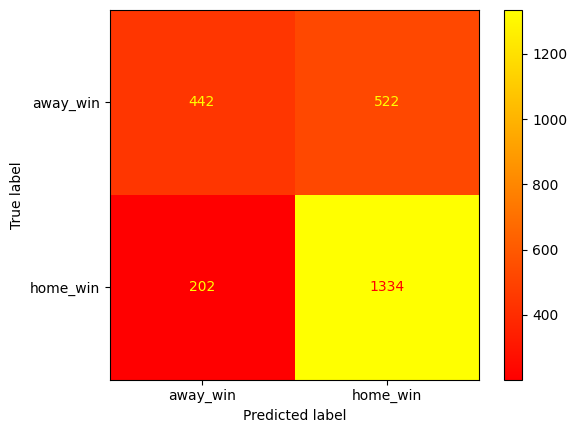

In [64]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['sag', 'saga'],
}

classes = np.unique(y_train)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)
class_weights = dict(zip(classes, class_weights_array))
logreg = LogisticRegression(
    # class_weight=class_weights, # это только хуже делает( Хуже делает на тесте... но может будет лучше на свежих данных...
    max_iter=2000,
    random_state=91
)

grid_search = GridSearchCV(logreg, param_grid, cv=8, scoring='f1_macro', n_jobs=-1, verbose=1)
grid_search.fit(X_train_processed, y_train, sample_weight=weights_train)
best_clf = grid_search.best_estimator_
scores = cross_val_score(best_clf, preprocessor.transform(X), y, cv=8, scoring='accuracy')
print("Best Params:", grid_search.best_params_)

best_clf.fit(X_train_processed, y_train, sample_weight=weights_train)

# tests
y_pred = best_clf.predict(X_test_processed)
cm = confusion_matrix(y_test, y_pred)

print(cm)
print(classification_report(y_test, y_pred, target_names=['away_win','home_win']))
ConfusionMatrixDisplay(cm, display_labels=['away_win','home_win']).plot(cmap='autumn')

with open('../backend/goalsight/ml_models/model.pkl', 'wb') as f:
    pickle.dump(best_clf, f)

metrics = {
    'cv_accuracy': scores.mean(),
    'cv_std': scores.std(),
    **classification_report(y_test, y_pred, output_dict=True)
}

metrics_path = '../backend/goalsight/ml_models/metrics.json'
with open(metrics_path, 'w') as f:
    json.dump(metrics, f, indent=2)

with open('../backend/goalsight/ml_models/preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

feature_list = [f for f in available_features if f != 'result_label']
with open('features.json', 'w') as f:
    json.dump(feature_list, f)

class_mapping = {"non_win": 0,"home_win": 1}
with open('class_mapping.json', 'w') as f:
    json.dump(class_mapping, f)

### MLP model Training & Validation & Testing

Fitting 8 folds for each of 64 candidates, totalling 512 fits
Лучшие параметры MLP: {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant'}
MLP CV accuracy: 0.7002 ± 0.0146
Confusion matrix for MLP:
[[ 451  513]
 [ 207 1329]]
Classification report for MLP:
              precision    recall  f1-score   support

    away_win       0.69      0.47      0.56       964
    home_win       0.72      0.87      0.79      1536

    accuracy                           0.71      2500
   macro avg       0.70      0.67      0.67      2500
weighted avg       0.71      0.71      0.70      2500



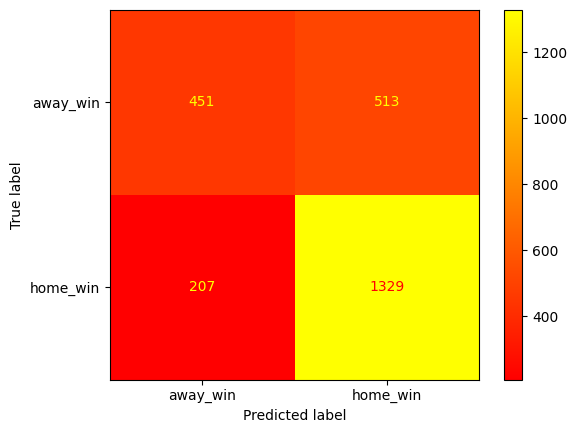

In [63]:
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 25), (100, 50)],
    'activation': ['relu', 'tanh'],
    'learning_rate': ['constant', 'adaptive'],
    'alpha': [0.0001, 0.001, 0.01, 0.1]
}

mlp = MLPClassifier(
    hidden_layer_sizes=(200,),
    activation='relu',
    learning_rate='adaptive',
    alpha=0.001,
    max_iter=2000,
    random_state=91,
    early_stopping=True,
    validation_fraction=0.15,
    n_iter_no_change=10
)

grid_search_mlp = GridSearchCV(
    mlp,
    param_grid,
    cv=8,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)
grid_search_mlp.fit(X_train_processed, y_train)
best_mlp = grid_search_mlp.best_estimator_
print("Лучшие параметры MLP:", grid_search_mlp.best_params_)
mlp_scores = cross_val_score(
    best_mlp,
    preprocessor.transform(X),
    y,
    cv=8,
    scoring='accuracy'
)
print(f"MLP CV accuracy: {mlp_scores.mean():.4f} ± {mlp_scores.std():.4f}")
best_mlp.fit(X_train_processed, y_train)
y_pred_mlp = best_mlp.predict(X_test_processed)
print("Confusion matrix for MLP:")
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
print(cm_mlp)
print("Classification report for MLP:")
print(classification_report(y_test, y_pred_mlp, target_names=['away_win','home_win']))
ConfusionMatrixDisplay(cm_mlp, display_labels=['away_win','home_win']).plot(cmap='autumn')

# # 6. Сохранение модели и метрик
# import pickle, json
# with open('../backend/goalsight/ml_models/mlp_model.pkl', 'wb') as f:
#     pickle.dump(best_mlp, f)
#
# metrics_mlp = {
#     'cv_accuracy': mlp_scores.mean(),
#     'cv_std': mlp_scores.std(),
#     **classification_report(y_test, y_pred_mlp, output_dict=True)
# }
# with open('../backend/goalsight/ml_models/mlp_metrics.json', 'w') as f:
#     json.dump(metrics_mlp, f, indent=2)
#
# print("MLP модель с регуляризацией успешно обучена и сохранена.")
